Импорт библиотек и загрузка данных

In [ ]:
# Установка необходимых библиотек (раскомментируйте, если нужно)
# !pip install nltk gensim torch scikit-learn matplotlib
!pip install gensim

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import nltk
from nltk.corpus import movie_reviews
import gensim
from gensim.models import Word2Vec

import numpy as np
import re
import string
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Загружаем датасет
nltk.download('movie_reviews')
nltk.download('punkt')

# Настраиваем устройство (GPU если есть, иначе CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 58.3 MB/s eta 0:00:00


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda


Подготовка и очистка данных

In [ ]:
# 1. Загрузка данных из NLTK
# movie_reviews содержит отзывы: 'pos' (положительные) и 'neg' (отрицательные)
documents = []
labels = []

for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
        # Получаем текст отзыва
        words = movie_reviews.words(fileid)
        # Метка: 1 для 'pos', 0 для 'neg'
        label = 1 if category == 'pos' else 0

        documents.append(list(words)) # NLTK уже возвращает список токенов
        labels.append(label)

print(f"Всего отзывов: {len(documents)}")
print(f"Пример отзыва (первые 10 слов): {documents[0][:10]}")

# 2. Очистка данных
def clean_tokens(tokens):
    """
    Удаляет пунктуацию, приводит к нижнему регистру,
    оставляет только слова, состоящие из букв.
    """
    clean = []
    for token in tokens:
        token = token.lower()
        # Проверяем, что токен не является знаком пунктуации и содержит буквы
        if token not in string.punctuation and token.isalpha():
            clean.append(token)
    return clean

# Применяем очистку ко всем документам
cleaned_docs = [clean_tokens(doc) for doc in documents]

print(f"Пример очищенного отзыва: {cleaned_docs[0][:10]}")

Всего отзывов: 2000
Пример отзыва (первые 10 слов): ['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party']
Пример очищенного отзыва: ['plot', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', 'drink']


Обучение Word2Vec

In [ ]:
# Параметры Word2Vec
EMBEDDING_DIM = 100  # Размерность вектора (как в примере )
WINDOW = 5           # Окно контекста
MIN_COUNT = 2        # Игнорируем слова, которые встречаются реже 2 раз
WORKERS = 4

# Обучение модели Gensim Word2Vec
w2v_model = Word2Vec(
    sentences=cleaned_docs,
    vector_size=EMBEDDING_DIM,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=WORKERS
)

print(f"Word2Vec обучен. Размер словаря: {len(w2v_model.wv)}")

# Проверка "семантики": посмотрим похожие слова
# Например, для слова 'good' (хороший)
try:
    print("Похожие слова для 'good':", w2v_model.wv.most_similar('good', topn=3))
    print("Похожие слова for 'bad':", w2v_model.wv.most_similar('bad', topn=3))
except KeyError:
    print("Слово не найдено в словаре")

Word2Vec обучен. Размер словаря: 25325
Похожие слова для 'good': [('bad', 0.8450252413749695), ('nice', 0.8226466178894043), ('great', 0.8047561049461365)]
Похожие слова for 'bad': [('good', 0.8450251817703247), ('nice', 0.7867920994758606), ('funny', 0.7499598860740662)]


Подготовка данных для Pytorch (Tokenization & Padding)

In [ ]:
# Создаем словарь: слово -> индекс
# 0 зарезервируем для паддинга (padding), 1 для неизвестных слов (unknown)
word2idx = {"<PAD>": 0, "<UNK>": 1}
# Добавляем слова из Word2Vec в наш словарь
for word in w2v_model.wv.index_to_key:
    word2idx[word] = len(word2idx)

# Параметр максимальной длины текста (для коротких текстов)
MAX_LEN = 200

def encode_and_pad(doc, word2idx, max_len):
    """
    Преобразует список слов в список индексов с паддингом/усечением.
    Логика из файла пояснений.
    """
    # Преобразуем слова в индексы
    encoded = [word2idx.get(word, word2idx["<UNK>"]) for word in doc]

    # Паддинг или усечение
    if len(encoded) < max_len:
        # Добавляем нули в конец, если текст короче max_len
        encoded += [0] * (max_len - len(encoded))
    else:
        # Обрезаем, если длиннее
        encoded = encoded[:max_len]

    return encoded

# Преобразуем все тексты в числовые векторы
X_data = [encode_and_pad(doc, word2idx, MAX_LEN) for doc in cleaned_docs]
X_data = np.array(X_data)
y_data = np.array(labels)

# Разделение на обучающую и тестовую выборки (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Создание TensorDataset и DataLoader для PyTorch
batch_size = 64

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.float))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.float))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 1600
Размер тестовой выборки: 400


Создание матрицы весов для Embedding слоя

In [ ]:
# Создаем матрицу весов для слоя Embedding
# Размер: (размер_словаря, размерность_вектора)
vocab_size = len(word2idx)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Заполняем матрицу векторами из Word2Vec
for word, idx in word2idx.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
    else:
        # Для <PAD> и <UNK> оставляем нули или инициализируем случайно
        # <PAD> обычно нули, <UNK> можно случайно
        if word == "<UNK>":
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMBEDDING_DIM, ))

# Конвертируем в тензор
embedding_weights = torch.tensor(embedding_matrix, dtype=torch.float32)

print(f"Матрица эмбеддингов создана. Размер: {embedding_weights.shape}")

Матрица эмбеддингов создана. Размер: torch.Size([25327, 100])


Построение RNN модели (LSTM)

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, embedding_weights):
        super(SentimentLSTM, self).__init__()

        # 1. Слой Embedding [cite: 14]
        # Загружаем предобученные веса
        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True, padding_idx=0)
        # freeze=True аналогично requires_grad=False, веса не будут меняться при обучении

        # 2. LSTM слой (можно заменить на RNN или GRU)
        self.lstm = nn.LSTM(embed_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            batch_first=True,
                            dropout=0.5) # Dropout для регуляризации

        # 3. Полносвязный слой для классификации
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Сигмоида для получения вероятности (0 или 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: [batch_size, seq_len]

        # Получаем эмбеддинги
        embeds = self.embedding(x) # shape: [batch_size, seq_len, embed_dim]

        # Прогоняем через LSTM
        # out: выходные данные для каждого шага
        # (hidden, cell): скрытые состояния последнего шага
        lstm_out, (hidden, cell) = self.lstm(embeds)

        # Берем скрытое состояние с последнего шага времени
        # hidden[-1] shape: [batch_size, hidden_dim]
        final_hidden_state = hidden[-1]

        # Прогоняем через полносвязный слой
        out = self.fc(final_hidden_state)

        # Функция активации для бинарной классификации
        return self.sigmoid(out)

# Гиперпараметры
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 2

# Инициализация модели
model = SentimentLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, embedding_weights)
model = model.to(device)

print(model)

SentimentLSTM(
  (embedding): Embedding(25327, 100, padding_idx=0)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Обучение модели

Начало обучения...
Epoch 1/20 | Train Loss: 0.6930 | Test Loss: 0.6948 | Train Acc: 0.5181 | Test Acc: 0.5424
Epoch 2/20 | Train Loss: 0.6864 | Test Loss: 0.6990 | Train Acc: 0.5619 | Test Acc: 0.5290
Epoch 3/20 | Train Loss: 0.6795 | Test Loss: 0.6948 | Train Acc: 0.5625 | Test Acc: 0.5201
Epoch 4/20 | Train Loss: 0.6718 | Test Loss: 0.7027 | Train Acc: 0.5994 | Test Acc: 0.5022
Epoch 5/20 | Train Loss: 0.6628 | Test Loss: 0.7035 | Train Acc: 0.6081 | Test Acc: 0.5558
Epoch 6/20 | Train Loss: 0.6498 | Test Loss: 0.7289 | Train Acc: 0.6256 | Test Acc: 0.5112
Epoch 7/20 | Train Loss: 0.6353 | Test Loss: 0.7155 | Train Acc: 0.6294 | Test Acc: 0.5558
Epoch 8/20 | Train Loss: 0.6128 | Test Loss: 0.7311 | Train Acc: 0.6750 | Test Acc: 0.5603
Epoch 9/20 | Train Loss: 0.5720 | Test Loss: 0.7974 | Train Acc: 0.7175 | Test Acc: 0.5647
Epoch 10/20 | Train Loss: 0.5408 | Test Loss: 0.8294 | Train Acc: 0.7394 | Test Acc: 0.5335
Epoch 11/20 | Train Loss: 0.4805 | Test Loss: 0.8305 | Train Acc: 0.77

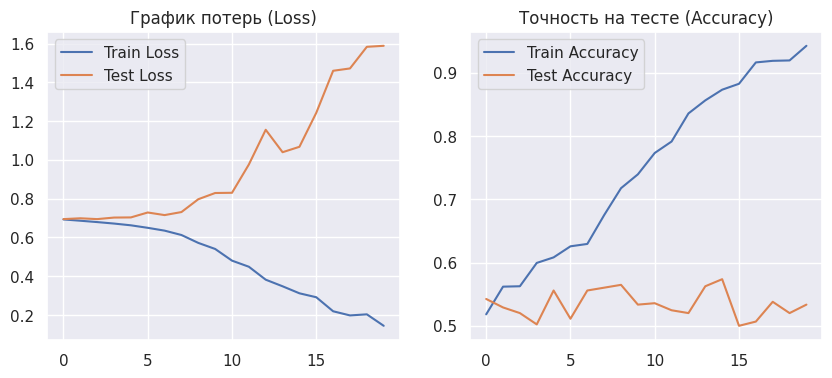

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def binary_accuracy(preds, y):
    """
    Вычисляет точность. Округляет предсказания (0.1 -> 0, 0.9 -> 1)
    и сравнивает с истинными метками.
    """
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

EPOCHS = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Начало обучения...")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()

        predictions = model(texts).squeeze(1) # Убираем лишнюю размерность [64, 1] -> [64]

        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # Оценка на тестовой выборке
    model.eval()
    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            acc = binary_accuracy(predictions, labels)
            test_acc += acc.item()

    avg_train_loss = epoch_loss / len(train_loader)
    avg_test_acc = test_acc / len(test_loader)
    avg_train_acc = epoch_acc / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    test_accuracies.append(avg_test_acc)
    train_accuracies.append(avg_train_acc)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Train Acc: {avg_train_acc:.4f} | Test Acc: {avg_test_acc:.4f}')

# Визуализация обучения [cite: 63]
import seaborn as sns
sns.set(style='darkgrid')
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('График потерь (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Точность на тесте (Accuracy)')
plt.legend()
plt.show()

Проверка модели (Inference) и выводы

In [ ]:
def predict_sentiment(text, model, word2idx, max_len):
    model.eval()
    # 1. Токенизация и очистка (как при обучении)
    tokens = clean_tokens(text.split()) # Используем простой split для новых текстов или NLTK word_tokenize
    # 2. Кодирование и паддинг
    encoded = encode_and_pad(tokens, word2idx, max_len)
    # 3. Преобразование в тензор
    tensor = torch.LongTensor(encoded).unsqueeze(0).to(device) # Добавляем размерность батча (1, max_len)
    # 4. Предсказание
    prediction = model(tensor).item()
    return prediction

print("\n--- Примеры предсказаний (10 отзывов) ---")

# Берем 10 примеров из тестового датасета (сырой текст)
# Нам нужно восстановить текст из индексов для наглядности (или взять исходные)
test_indices = X_test[:10]
test_labels = y_test[:10]

# Словарь для обратного преобразования (индекс -> слово)
idx2word = {v: k for k, v in word2idx.items()}

for i in range(10):
    # Восстанавливаем текст (без паддинга)
    text_indices = [idx for idx in test_indices[i] if idx != 0]
    text = " ".join([idx2word.get(idx, "") for idx in text_indices])

    true_label = "Positive" if test_labels[i] == 1 else "Negative"

    # Предсказываем
    # Мы передаем уже тензор в модель, но для чистоты эксперимента используем функцию predict
    # (здесь мы просто прогоним тензор напрямую для скорости)
    with torch.no_grad():
        input_tensor = torch.tensor(test_indices[i], dtype=torch.long).unsqueeze(0).to(device)
        pred_prob = model(input_tensor).item()

    pred_label = "Positive" if pred_prob >= 0.5 else "Negative"

    print(f"Отзыв {i+1}: {text[:60]}...") # Показываем начало отзыва
    print(f"  True: {true_label} | Pred: {pred_label} ({pred_prob:.4f})")
    print("-" * 30)

print(f"\nИтоговая точность на тестовой выборке: {test_accuracies[-1]*100:.2f}%")


--- Примеры предсказаний (10 отзывов) ---
Отзыв 1: the verdict spine chilling drama from horror maestro stephen...
  True: Positive | Pred: Positive (0.9321)
------------------------------
Отзыв 2: the caliber killer has struck again starring john leguizamo ...
  True: Negative | Pred: Positive (0.9696)
------------------------------
Отзыв 3: in the company of men made a splash at the sundance film fes...
  True: Positive | Pred: Negative (0.0366)
------------------------------
Отзыв 4: in the year captain leo davidson mark wahlberg boogie nights...
  True: Negative | Pred: Positive (0.9965)
------------------------------
Отзыв 5: note that <UNK> are directed to rec arts movies current film...
  True: Positive | Pred: Positive (0.9979)
------------------------------
Отзыв 6: felix sami bouajila the siege lives a contented life with hi...
  True: Positive | Pred: Positive (0.8684)
------------------------------
Отзыв 7: synopsis a maniac crazed by virulent <UNK> slaughters more t...
  